#### This python notebook looks at the relationship between stages of the Monsoon (burst) and Extreme Events

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from netCDF4 import Dataset as nc, num2date, MFDataset as mc
import os
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
sns.set_style("whitegrid")
from DataFrame import *
from datetime import datetime

Define the path's where data is storde

In [2]:
largeScaleFile = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL-large-scale_forcing.pkl')
largeScaleNc = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL-large-scale_forcing.nc')
CPOL = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_1998-2017.nc')
CopF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL-Aggr.hdf5')
BurstF = os.path.join(os.environ['HOME'], 'Data', 'Extremes', 'CPOL', 'CPOL_datetimes_austmonsoon_burstday_lags.pkl')
PercF = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_Percentiles.pkl')
RegimeF = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','Pope_Regimes.pkl')
extreme1h = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL-TS_1hextrme.pkl')
BurstCat = os.path.join(os.environ['HOME'],'Data','Extremes','CPOL','CPOL_datetimes_austmonsoon_burst_categories.pkl')

In [3]:
cop = pd.read_hdf(CopF)
extr1h = pd.read_pickle(extreme1h)
cop.loc[cop['cop'] == np.inf,'cop'] = 200.
perc = pd.read_pickle(PercF)
burst10m = pd.read_pickle(BurstF)
burst10m = burst10m.loc[cop.index[0]:]
pope10m = pd.read_pickle(RegimeF)
pope10m2 = pd.read_pickle(RegimeF)
burstcat = pd.read_pickle(BurstCat)
a = pd.Series(np.zeros(len(burstcat)),index=burstcat.index)
b = pd.Series(np.zeros(len(burstcat)),index=burstcat.index)
a.loc[burstcat == 'notburst'] = 1
b.loc[burstcat != 'notburst'] = 1
burst10m['0'] = a
burst10m['2'] = b
burst10m = burst10m.dropna()
su = burst10m.iloc[:,:3].sum(axis=1)
burst10m.loc[su == 1, '0'] = 0
bursth1 = burst10m.groupby(pd.TimeGrouper('1h')).mean()
prior = burst10m.iloc[:,:3].dropna().sum(axis=1)
prior = prior.index[prior.values == 1]
burst = burst10m.iloc[:,3].dropna()
burst = burst.loc[burst == 1].index
post = burst10m['2'].loc[burst10m['2'] == 1].index
#post = burst10m.iloc[:,4:-1].dropna().sum(axis=1)
#post = post.loc[post == 1].index



#R1 = pope10m.loc[pope10m == 1]
p1 = pope10m.loc[prior]
p2 = pope10m.loc[burst]
p3 = pope10m.loc[post]
regimes = {1:'DryEast',2:'DeepWest',3:'East',4:'ShalWest', 5:'MoistEast'}
for i in range(1,6):
    pope10m.loc[pope10m == i] = regimes[i]

In [4]:
regCount = []
names = []
for reg in range(1,6):
    regCount.append(int(p2.loc[p2==reg].count()/144))
    names.append(regimes[reg])
regCount = pd.Series(regCount,index=names)
#regCount = pd.DataFrame(np.array(regCount).T, columns=regimes)
regCount.iplot(kind='bar', filename='pre-burst_Count',yTitle='Count of Break Days',xTitle='Regime',
                  title='Monsoon Break vs. Rainfall Regime')


In [5]:
regCount=[]
names =[]
for reg in range(1,6):
    regCount.append(int(p1.loc[p1==reg].count()/144))
    names.append(regimes[reg])
regCount = pd.Series(regCount,index=names)
#regCount = pd.DataFrame(np.array(regCount).T, columns=regimes)
regCount.iplot(kind='bar', filename='burst_Count',yTitle='Count of Days prior to burst',xTitle='Regime',
                  title='Prior to Monsoon Burst vs. Rainfall Regime')


In [7]:
regCount=[]
names =[]
for reg in range(1,6):
    regCount.append(int(p3.loc[p3==reg].count()/144))
    names.append(regimes[reg])
regCount = pd.Series(regCount,index=names)
#regCount = pd.DataFrame(np.array(regCount).T, columns=regimes)
regCount.iplot(kind='bar', filename='pre-burst_Count',yTitle='Count of Burst Days',xTitle='Regime',
                  title='Monsoon Burst vs. Rainfall Regime')

### Monsoon Stuff

In [8]:
burst_cnt = []
names = ['Break', 'Before Burst', 'Burst']
burstTS = burst10m.loc[extr1h.index].dropna()
extr_events = burstTS.loc[extr1h == 1].index
extr_burst = burstTS.loc[extr_events]
prior1h = burstTS.iloc[:,:3].sum(axis=1)
prior1h = prior1h.index[prior1h.values == 1]
burst1h = burstTS.iloc[:,3]
burst1h = burstTS.loc[burst1h == 1].index
post1h = burstTS.iloc[:,4:-1].dropna().sum(axis=1)
post1h = post1h.loc[post1h == 1].index

Nb = len(burstTS)
Np = len(burstTS)
Ne = len(extr_events)

prior_ext = extr_burst.iloc[:,:3].sum(axis=1)
prior_ext = prior_ext.index[prior_ext.values == 1]
burst_ext = extr_burst.iloc[:,3]
burst_ext = burst_ext.loc[burst_ext == 1].index
post_ext = extr_burst.iloc[:,4:-1].sum(axis=1)
post_ext = post_ext.loc[post_ext == 1].index
ii = 1
for ext,cat in ((burst_ext,burst1h), (prior_ext,prior1h),(post_ext,post1h)):
    Pbe = len(ext)/len(extr1h.dropna()) *100.
    print(Pbe,Ne/Np*100*len(cat)/len(burstp))
    if ii == 3:
        burst_cnt.append(Pbe/ (Ne/Np) - 2)
    else:
         burst_cnt.append(Pbe/ (Ne/Np))
    ii += 1
#    N = extrreg.loc[extrreg==float(reg)].count()
#    reg_cnt.append(100 * N/M)
#    names.append(regimes[reg])
burst_cnt = pd.Series(burst_cnt,index=names)
burst_cnt.iplot(kind='bar', filename='reg_Count',yTitle='P(Stage|Extreme)',xTitle='Monsoon Stage',
                  title='Extreme Events vs. Monsoon Stage')


NameError: name 'burstp' is not defined

In [528]:
burst_cnt = []
ii = 1
for ext,cat in ((burst_ext,burst1h), (prior_ext,prior1h),(post_ext,post1h)):
    #Pbe = len(ext)/len(extr1h.dropna()) *100.
    Pbe = len(ext)/Ne * 100 / len(cat)
    
    if ii == 3:
        Pbe *= 0.75
    ii+=1
    
    burst_cnt.append(Pbe)
burst_cnt = pd.Series(burst_cnt,index=names)
print(burst_cnt.values.sum())
burst_cnt.iplot(kind='bar', filename='reg_Count',yTitle='Frequency of Extremes (weighted)',xTitle='Monsoon Stage',
                  title='Extreme Events vs. Monsoon Stage')

0.008135175701805861


70.0

In [530]:
# First for rainfall regimes
cop_burst = []
cop1h = cop.groupby(pd.TimeGrouper('1h')).mean()
cop_burst.append({
            "type": 'violin',
            #'x': np.repeat('PreBurst',len(cop1h.loc[post_ext,'nclu'].values)),
            "y": cop1h.loc[burst_ext,'cop'].values,
            "name": 'Break',
            #"side": 'positive',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            }
        })
cop_burst.append({
            "type": 'violin',
            #'x': np.repeat('PreBurst',len(cop1h.loc[post_ext,'nclu'].values)),
            "y": cop1h.loc[prior_ext,'cop'].values,
            "name": 'PriorBurst',
            #"side": 'positive',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            }
        })
cop_burst.append({
            "type": 'violin',
            #'x': np.repeat('PreBurst',len(cop1h.loc[post_ext,'nclu'].values)),
            "y": cop1h.loc[post_ext,'cop'].values,
            "name": 'Burst',
            #"side": 'positive',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            }
        })

fig_2 = {
    "data": cop_burst,
    "layout" : {
        "title": "Convective Organisation vs Monsoon Stage",
        "yaxis": {
            "zeroline": False,
            "title": "Number of Convective objects [ ]"
            
        }
    }
}

In [531]:
py.iplot(fig_2, filename='cop_violine',validate=False)

### Regime Stuff

In [411]:
reg_cnt = []
names = []
idx1 = extr1h.loc[extr1h == 1].index
pope1h = pope10m2.groupby(pd.TimeGrouper('1h')).mean()

extrreg = pope1h.loc[idx1]
M = len(idx1)
pope1h = pope10m2.groupby(pd.TimeGrouper('1h')).mean().dropna()
for reg in range(1,6):
    N = extrreg.loc[extrreg==float(reg)].count()
    reg_cnt.append(100 * N/len(pope1h) / (len(idx1)/len(extr1h)))
    #reg_cnt.append(100 * N/M) #/ (len(idx1)/len(extr1h)))
    names.append(regimes[reg])
reg_cnt = pd.Series(reg_cnt,index=names)
reg_cnt.iplot(kind='bar', filename='reg_Count',yTitle='P(Regime|Extrme)',xTitle='Regime',
                  title='Extreme Events vs. Rainfall Regime')

In [410]:
reg_cnt = []
names = []
idx1 = extr1h.loc[extr1h == 1].index
pope1h = pope10m2.groupby(pd.TimeGrouper('1h')).mean()

extrreg = pope1h.loc[idx1]
M = len(idx1)
pope1h = pope10m2.groupby(pd.TimeGrouper('1h')).mean().dropna()
for reg in range(1,6):
    N = extrreg.loc[extrreg==float(reg)].count()
    #reg_cnt.append(100 * N/len(pope1h) / (len(idx1)/len(extr1h)))
    reg_cnt.append(100 * N/M) #/ (len(idx1)/len(extr1h)))
    names.append(regimes[reg])
print(np.array(reg_cnt).sum())
reg_cnt = pd.Series(reg_cnt,index=names)
reg_cnt.iplot(kind='bar', filename='reg_Count',yTitle='Frequency of Event Occurrance',xTitle='Regime',
                  title='Extreme Events vs. Rainfall Regime')

96.2391844427311


### Organization Stuff

In [426]:
# First for rainfall regimes
cop_reg = []
cop1h = cop.groupby(pd.TimeGrouper('1h')).mean()
idx1 = extr1h.loc[extr1h == 1].index
copextr = cop.loc[idx1].dropna()
copextr['regime'] = pope10m.loc[idx1]
copextr = copextr.dropna()

cop_reg.append({
            "type": 'violin',
            'x': np.repeat('All',len(copextr['size'].values)),
            "y": copextr['nclu'].values,
            "name": 'All',
            #"side": 'positive',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            }
        })
'''
cop_reg.append(
    {
            "type": 'violin',
            'x': np.repeat('All',len(copextr['nclu'].values)),
            "y": copextr['nclu'].values,
            "name": 'Convective Objects',
            'side':'negative',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            }
        }

)
'''
for reg in range(1,6):
        cop_reg.append({
            "type": 'violin',
            'x': copextr['regime'].loc[copextr['regime']== regimes[reg]],
            "y": copextr['nclu'].loc[copextr['regime'] == regimes[reg]].values,
            "name": regimes[reg],
           # 'side': 'positive',
            "box": {"visible": True},"meanline": {"visible": True}})
        '''
        cop_reg.append({
            "type": 'violin',
            'x': copextr['regime'].loc[copextr['regime']== regimes[reg]],
            "y": copextr['nclu'].loc[copextr['regime'] == regimes[reg]].values,
            "name": 'Convective Objects',
            'side': 'negative',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            }
        })'''
        
        
    
fig_1 = {
    "data": cop_reg,
    "layout" : {
        "title": "Convective Organisation across Different Rainfall Regimes",
        "yaxis": {
            "zeroline": False,
            "title": "Nuber of Convective Objects [ ]"
            
        }
    }
}

In [427]:
py.iplot(fig_1, filename='cop_violine',validate=False)

### Maps of frequency

In [311]:
from mpl_toolkits.basemap import Basemap

In [9]:
with nc(CPOL) as fnc:
    lon = fnc.variables['lon'][:]
    lat = fnc.variables['lat'][:]
    time = pd.DatetimeIndex(num2date(fnc['1h'].variables['time'][:],fnc['1h'].variables['time'].units))
    rr = fnc['1h'].variables['rain_rate-flip'][:]

In [312]:
m = Basemap(llcrnrlat=min(lat), llcrnrlon=min(lon), urcrnrlat=max(lat), urcrnrlon=max(lon), resolution='f')

In [468]:
with nc(CPOL) as fnc:
    rr10min = fnc['10min'].variables['rain_rate'][2495]
    rr6h = fnc['6h'].variables['rain_rate'][69]
    rr24h = fnc['24h'].variables['rain_rate'][17]


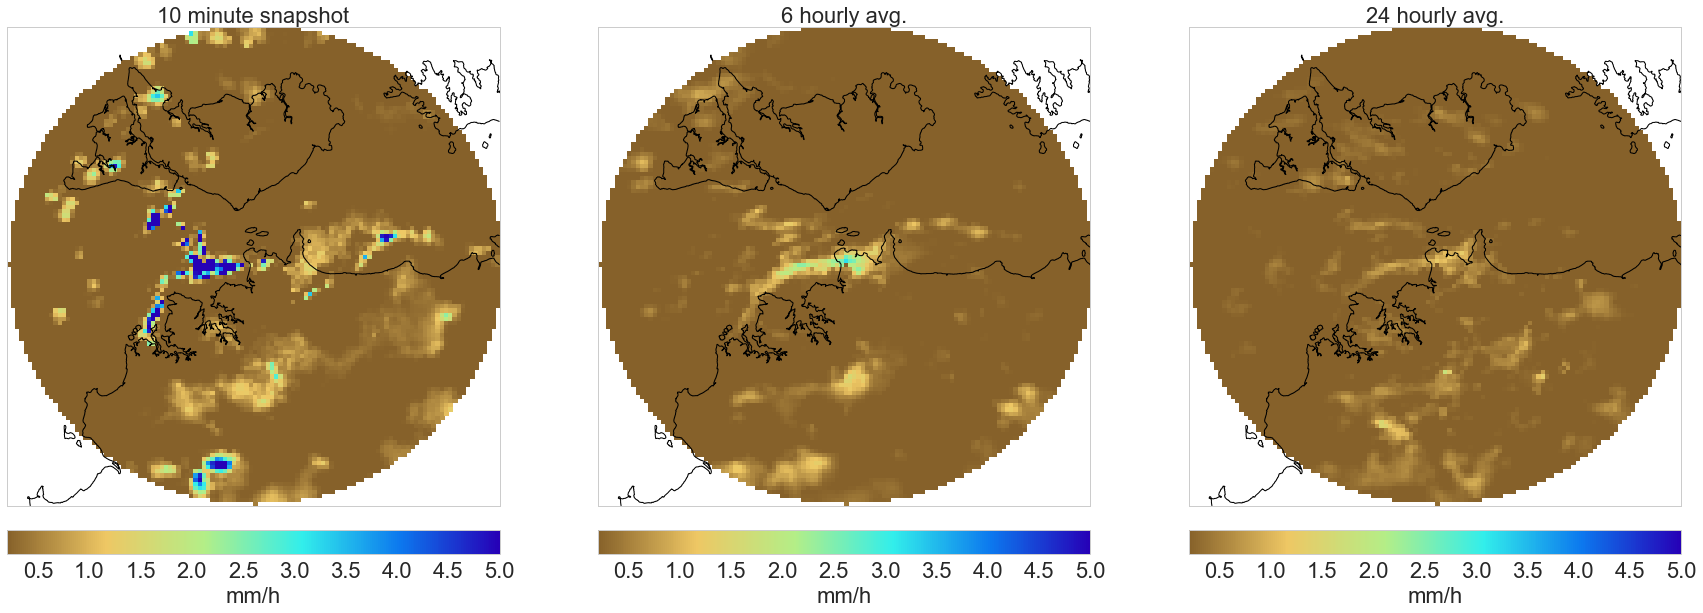

In [492]:
names = ['10 minute snapshot', '6 hourly avg.', '24 hourly avg.']
fig = plt.figure()
mpl.rcParams['figure.figsize'] = [30,30]

from mpl_toolkits.basemap import cm
for i, rain in enumerate((rr10min,rr6h,rr24h)):
    ax = fig.add_subplot(1,3,i+1)
    im = m.pcolormesh(lon, lat, rain,vmin=0.2,vmax=5,cmap=cm.GMT_drywet)
    m.drawcoastlines(color='k')
    cbar=m.colorbar(im,location='bottom',pad='5%')
    cbar.set_label('mm/h',size=22)
    cbar.ax.tick_params(labelsize=22)
    ax.set_title(names[i],size=22)

In [11]:
thresh = perc['01h_2.5km'][99]
S = pd.Series(np.arange(len(time)),index=time)
S.loc[time].values

array([    0,     1,     2, ..., 60789, 60790, 60791])

In [12]:
D = []
data = np.zeros([117,117])
for i in (time, post1h, burst1h, prior1h):
    tt = S.loc[i].values
    D.append((( np.ma.masked_less(rr[:,:,tt],thresh) * 0 ) + 1 ).sum(axis=-1))

In [514]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [16.0,16.0]

In [ ]:
with nc(os.path.join(os.getenv('HOME')),'test.nc','w') as tmp:
    tmp.createVariable('')

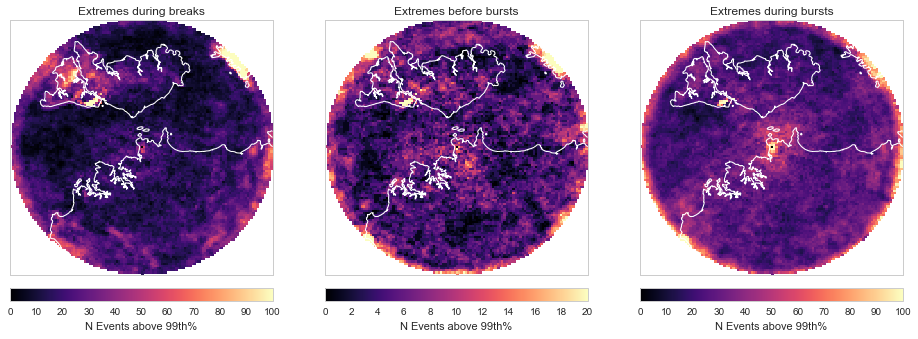

In [520]:
names=['(total)','during breaks','before bursts','during bursts']
maxval =[240, 100, 20, 100]
C = [D[0],D[2],D[3],D[1]]
C[1] =D[1]*0.75
fig = plt.figure()
mask = (D[0] * 0 )+1
for i, idx in enumerate((post1h, burst1h, prior1h)):
    ax = fig.add_subplot(1,3,i+1)
    data = np.zeros([117,117])
    #tt = S.loc[time].values
    #data = (( np.ma.masked_less(rr[:,:,tt],thresh) * 0 ) + 1 ).sum(axis=-1)
    try:
        im = m.pcolormesh(lon, lat, mask*C[i+1].filled(0),vmax=maxval[i+1],cmap=mpl.cm.magma)
    except AttributeError:
        im = m.pcolormesh(lon, lat, mask*C[i+1],vmax=maxval[i+1],cmap=mpl.cm.magma)
    m.drawcoastlines(color='w')
    cbar=m.colorbar(im,location='bottom',pad='5%')
    cbar.set_label(u'N Events above 99th%')
    ax.set_title('Extremes %s'%names[i+1])


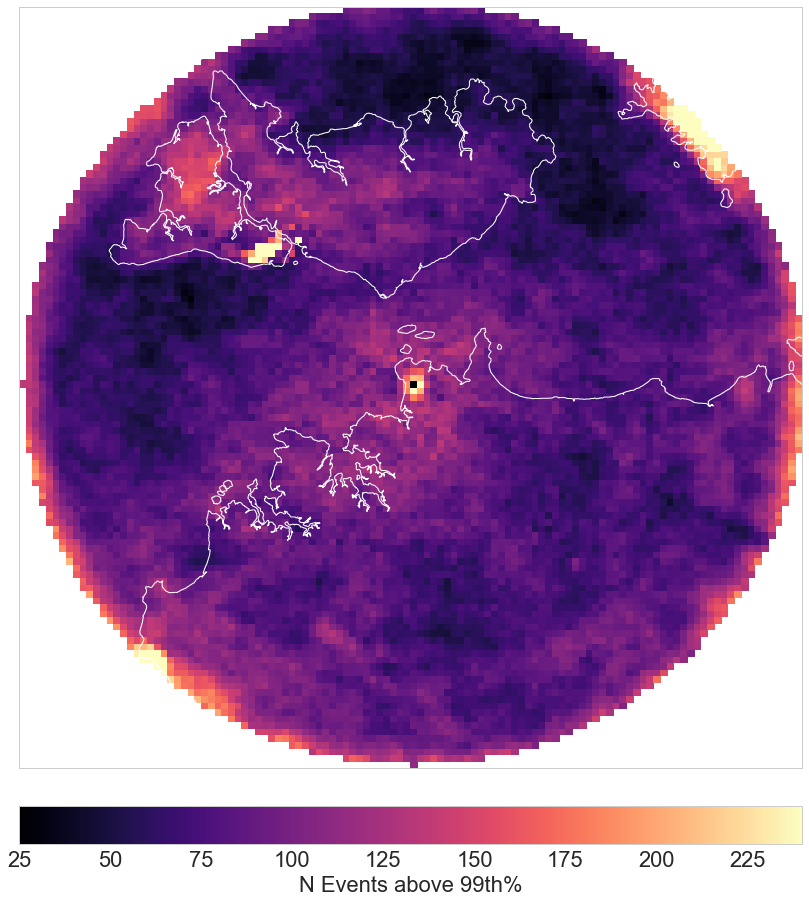

In [450]:
ax = fig.add_subplot(111)
i=0
mpl.rcParams['figure.figsize'] = [15,15]
try:
    im = m.pcolormesh(lon, lat, mask*C[i].filled(0),vmax=maxval[i],cmap=mpl.cm.magma)
except AttributeError:
    im = m.pcolormesh(lon, lat, mask*C[i],vmax=maxval[i],cmap=mpl.cm.magma)
m.drawcoastlines(color='w')
cbar=m.colorbar(im,location='bottom',pad='5%')
cbar.set_label(u'N Events above 99th%',size=22)
cbar.ax.tick_params(labelsize=22) 
ax.set_title('Extremes %s'%names[i])